In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import scipy as sp
import os, sys,glob, copy
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('default')
%matplotlib inline
import seaborn as sns

sys.path.append("/Users/xiaoxuanj/work/work_allen/Ephys/code_library/ephys_code/")

import data_loader as dl

import get_layer_dict as gd

import matrix_utils as mu

In [2]:
def condense_channel_matrix(tmp_X, df, case='between'):

    # combine units for each channel 
    new_matrix=np.zeros((len(depth_all), len(depth_all)))*np.NaN
    for i in range(len(depth_all)):
        for j in range(len(depth_all)):
            tmp_i = np.where((df.probe_id==new_probes[i]) & (df.channel_id==depth_all[i]))[0]
            tmp_j = np.where((df.probe_id==new_probes[j]) & (df.channel_id==depth_all[j]))[0]
            # removed within area
            if case=='between':
                if new_probes[i]!=new_probes[j]: 
                    if len(tmp_i)>1 or len(tmp_j)>1:
                        amo = np.nanmean(tmp_X[np.ix_(tmp_i, tmp_j)].flatten())
                    else:
                        amo = tmp_X[tmp_i, tmp_j]
                    new_matrix[i,j]=amo
            elif case=='within':
                if new_probes[i]==new_probes[j]: 
                    if len(tmp_i)>1 or len(tmp_j)>1:
                        amo = np.nanmean(tmp_X[np.ix_(tmp_i, tmp_j)].flatten())
                    else:
                        amo = tmp_X[tmp_i, tmp_j]
                    new_matrix[i,j]=amo
            elif case=='all':
                if len(tmp_i)>1 or len(tmp_j)>1:
                    amo = np.nanmean(tmp_X[np.ix_(tmp_i, tmp_j)].flatten())
                else:
                    amo = tmp_X[tmp_i, tmp_j]
                new_matrix[i,j]=amo
            else:
                print('case not specified!')
    return new_matrix

In [3]:
import networkx as nx
color_bank = {'probeA':'r',
                 'probeB':'brown',
                 'probeC': '#ff8c00',
                 'probeD': 'green',
                 'probeE': 'purple',
                 'probeF': 'blue'}

def plot_circle(t, r=1, center=[0,0]):
    x = r*np.cos(t) + center[0]
    y = r*np.sin(t) + center[1]
    return x, y

def set_nodes_position(df, depth_all, plot=False):  
    """
    set node location as function of channel id (depth)
    """
    n_nodes = len(depth_all)
    pos_probe={}
    pos_probe['probeC']=np.arange(250,310,0.6)/180.*np.pi
    pos_probe['probeD']=np.arange(180,240,0.6)/180.*np.pi
    pos_probe['probeE']=np.arange(120,180,0.6)/180.*np.pi
    pos_probe['probeF']=np.arange(60,120,0.6)/180.*np.pi
    pos_probe['probeA']=np.arange(0,60,0.6)/180.*np.pi
    pos_probe['probeB']=np.arange(310,360,0.4)/180.*np.pi


    probenames = df.probe_id.unique()
    t=[]
    for probe in probenames:
        chs = df[df.probe_id==probe].channel_id.unique()
        chs = chs-min(chs)
        if len(pos_probe[probe])>max(chs):
            t.append(pos_probe[probe][chs+1])
        else:
            print('Not enough nodes in '+probe+'. Add nodes!')
    t=np.concatenate(t, axis=0)
    print(len(t))

    pos={}
    for idx, a in enumerate(t):
        x, y = plot_circle(a)
        pos[idx]=np.array([x, y])

    # nodes id list for each probe
    probe_list={}
    for idx, probe in enumerate(probenames):
        probe_list[probe]=np.arange(n_nodes)[np.where(new_probes==probe)[0]]

    if plot==True:
        FG = nx.Graph()
        # draw nodes
        for p in probenames:
            nx.draw_networkx_nodes(FG,pos,
                                   nodelist=list(probe_list[p]),
                                   node_color=color_bank[p],
                                   node_size=10,
                                   alpha=0.6)
        plt.axis('equal')

    labels={}
    for i in range(n_nodes):
        labels[i]=int(depth_all[i])
    
    return pos, probe_list, labels

# plot matrix between driver and driven units

In [28]:
matrix = X[np.ix_(np.where(df.cluster==3)[0], np.where(df.cluster==3)[0])]
matrix.shape

(81, 81)

415149
140
140
140
140


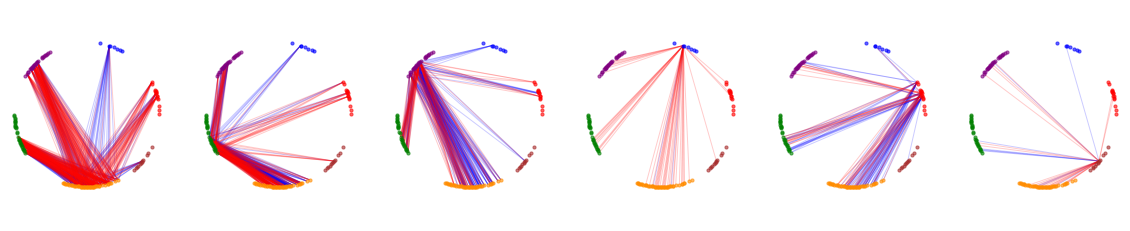

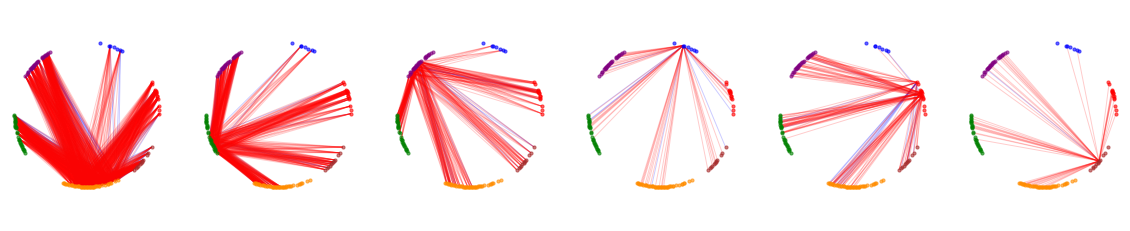

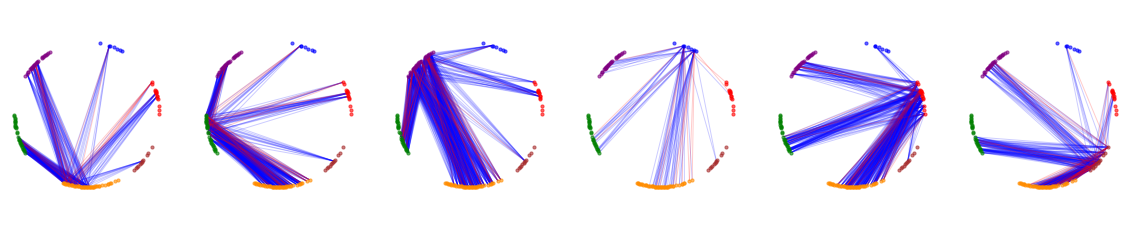

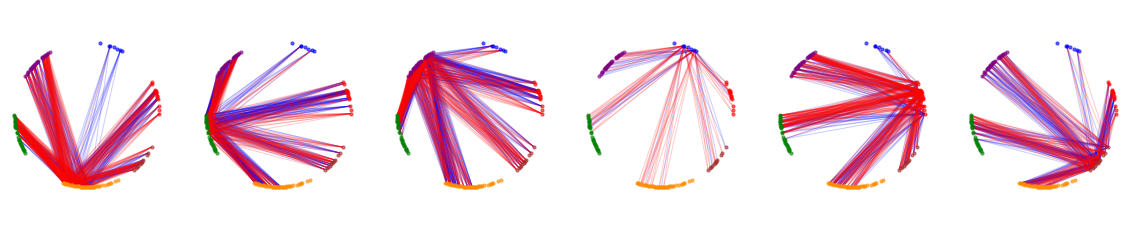

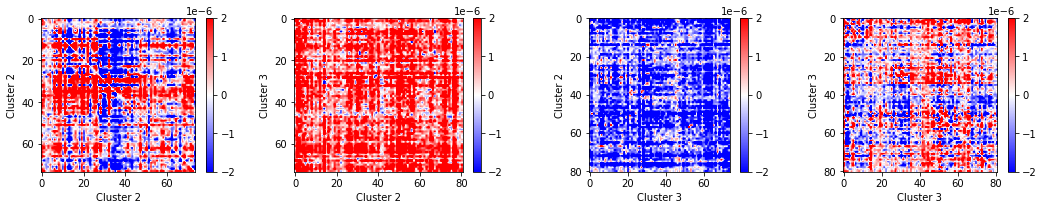

In [26]:
mouse_IDs = ['306046','388523', '389262',  '408153','410344', '415149', '412809', '412804',
             '416856', '419114',  '419117', '419118', '419119', '424445',
             '415148', '416356', '416861','419112','419116']

probe_reorder = ['probeC','probeD','probeE','probeF','probeA','probeB']
threshold=0.0000002

verbose = True

mouse_IDs = ['415149'] 

P_total=[]
DF_drive=[]
DF=[]
for mouse_ID in mouse_IDs:
    print(mouse_ID)
    # 1. load df
    X = np.load('/Users/xiaoxuanj/work/work_allen/Ephys/processed_data/adjacency_matrix/RF_onscreen/mouse'+mouse_ID+'_adjacency_matrix_RF.npy')
    
    df = pd.read_csv('/Users/xiaoxuanj/work/work_allen/Ephys/processed_data/meta_cluster_RF_old/mouse'+mouse_ID+'_meta_cluster_RF.csv')
    
    # get unique depth for each probe
    depth={}
    depth_all=[]
    new_probes=[]
    probenames = df.probe_id.unique()
    for probe in probenames:
        tmp = df[df.probe_id==probe].channel_id.unique()
        depth[probe]=list(tmp)
        depth_all.append(list(tmp))
        new_probes.append([probe]*len(tmp))
    depth_all = np.concatenate(depth_all, axis=0)
    new_probes = np.concatenate(new_probes, axis=0)
    n_nodes = len(depth_all)
    
    case='between'
    for m in [2,3]:
        for n in [2,3]:
            matrix = X[np.ix_(np.where(df.cluster==m)[0], np.where(df.cluster==n)[0])]
            tmp_X=np.zeros(np.shape(X))
            tmp_X[np.ix_(np.where(df.cluster==m)[0], np.where(df.cluster==n)[0])]=matrix

            new_matrix = condense_channel_matrix(tmp_X, df, case=case)
            pos, probe_list, labels = set_nodes_position(df, depth_all)
            
                        # for abstract figure with selected interarea connections
            
            plt.figure(figsize=(20,4))
            for idx, probe in enumerate(probe_reorder):
                plt.subplot(1,6,idx+1)
                FG = nx.Graph()
                # draw nodes
                for p in probenames:
                    nx.draw_networkx_nodes(FG,pos,
                                           nodelist=list(probe_list[p]),
                                           node_color=color_bank[p],
                                           node_size=10,
                                           alpha=0.6)
                plt.axis('equal')

                edgeP=new_matrix
                # add positive edge
                for i in probe_list[probe]:
                    for j in range(n_nodes):
                        if i!=j:
                            if abs(edgeP[i,j])>0.0000001:
                                FG.add_weighted_edges_from([(i,j, edgeP[i,j])])
                                
                elarge_neg=[(u,v) for (u,v,d) in FG.edges(data=True) if d['weight'] <-threshold]
                nx.draw_networkx_edges(FG,pos,edgelist=elarge_neg,width=1,edge_color='b', alpha=0.2)

                elarge_pos=[(u,v) for (u,v,d) in FG.edges(data=True) if d['weight'] >threshold]
                nx.draw_networkx_edges(FG,pos,edgelist=elarge_pos,width=1,edge_color='r', alpha=0.2)
                
                #import random
                #elarge_neg=[(u,v) for (u,v,d) in FG.edges(data=True) if d['weight'] <-threshold]
                #elarge_pos=[(u,v) for (u,v,d) in FG.edges(data=True) if d['weight'] >threshold]
                
                #random.shuffle(elarge_neg)
                #random.shuffle(elarge_pos)
                #for i in range(min(len(elarge_neg), len(elarge_pos))):
                #    nx.draw_networkx_edges(FG,pos,edgelist=[elarge_neg[i]],width=1,edge_color='b', alpha=0.2)
                #    nx.draw_networkx_edges(FG,pos,edgelist=[elarge_pos[i]],width=1,edge_color='r', alpha=0.2)

                plt.axis('off')
            #plt.savefig('/Users/xiaoxuanj/Documents/presentations/CCN2019/presentation/figures/mouse'+mouse_ID+'_subnetworks_nx_cluster'+str(m)+str(n)+'_all_balanced.pdf')
            plt.savefig('/Users/xiaoxuanj/Documents/presentations/CCN2019/presentation/figures/mouse'+mouse_ID+'_subnetworks_nx_cluster'+str(m)+str(n)+'_all.pdf')
            
            #plt.savefig('/Users/xiaoxuanj/Documents/Paper_functional_connectivity/materials/mouse'+mouse_ID+'_subnetworks_nx_cluster'+str(m)+str(n)+'_all000001.pdf')
    plt.figure(figsize=(15,3))
    plt.subplot(141)
    plt.imshow(X[np.ix_(np.where(df.cluster==2)[0], np.where(df.cluster==2)[0])], vmax=0.000002,vmin=-0.000002,cmap='bwr')
    plt.colorbar()
    plt.xlabel('Cluster 2')
    plt.ylabel('Cluster 2')

    plt.subplot(142)
    plt.imshow(X[np.ix_(np.where(df.cluster==2)[0], np.where(df.cluster==3)[0])], vmax=0.000002,vmin=-0.000002,cmap='bwr')
    plt.colorbar()
    plt.xlabel('Cluster 2')
    plt.ylabel('Cluster 3')

    plt.subplot(143)
    plt.imshow(X[np.ix_(np.where(df.cluster==3)[0], np.where(df.cluster==2)[0])], vmax=0.000002,vmin=-0.000002,cmap='bwr')
    plt.colorbar()
    plt.xlabel('Cluster 3')
    plt.ylabel('Cluster 2')
    
    plt.subplot(144)
    plt.imshow(X[np.ix_(np.where(df.cluster==3)[0], np.where(df.cluster==3)[0])], vmax=0.000002,vmin=-0.000002,cmap='bwr')
    plt.colorbar()
    plt.xlabel('Cluster 3')
    plt.ylabel('Cluster 3')
    plt.tight_layout()
    #plt.savefig('/Users/xiaoxuanj/Documents/presentations/CCN2019/presentation/figures/mouse'+mouse_ID+'_subnetworks_matrix.pdf')
    #plt.savefig('/Users/xiaoxuanj/Documents/Paper_functional_connectivity/materials/mouse'+mouse_ID+'_subnetworks_matrix.pdf')


# plot driver and driven network in the same graph

306046
154
388523
120
389262
84
408153
139
410344
132
415149
140
412809
134
412804
106
416357
59
416856
123
419114
168
419115
76
419117
115
419118
126
419119
133
424445
130


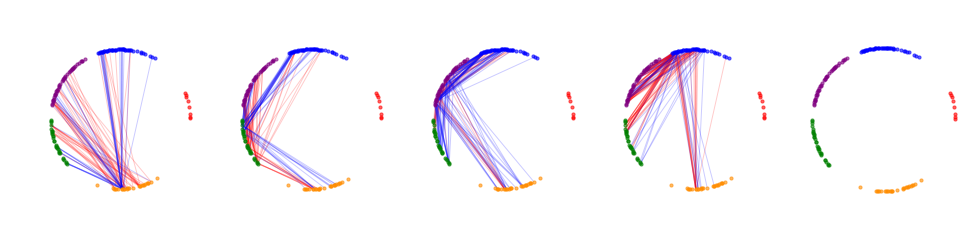

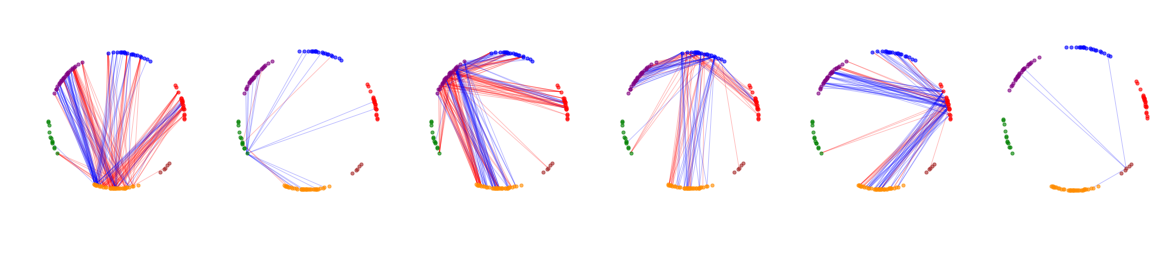

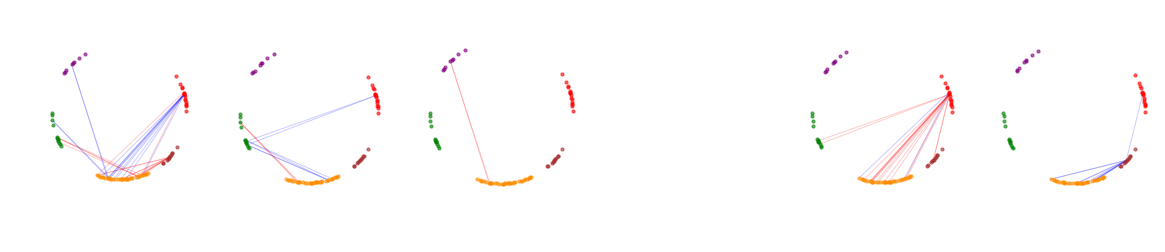

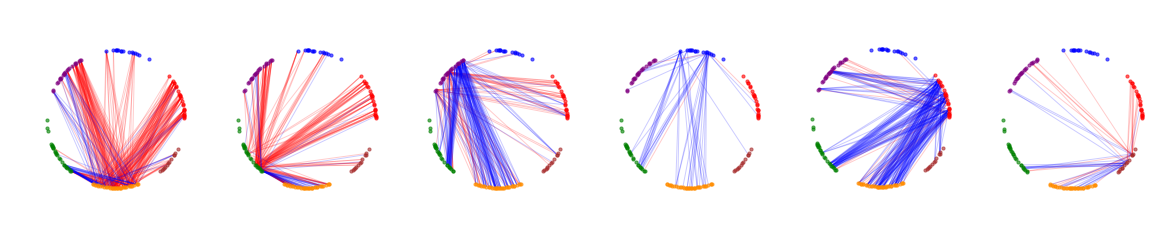

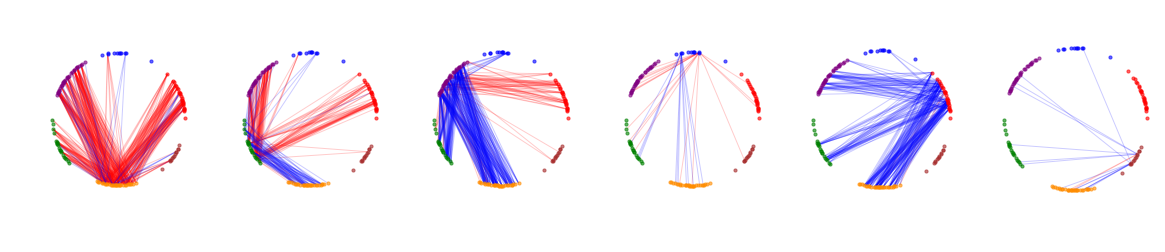

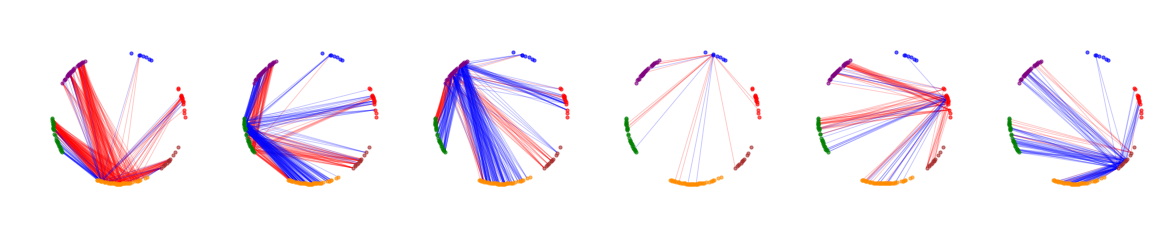

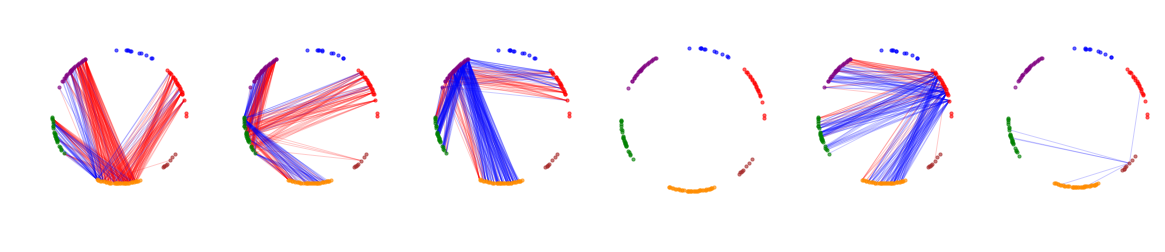

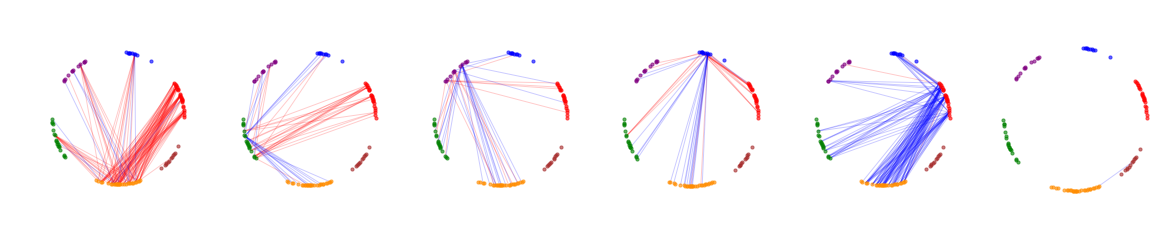

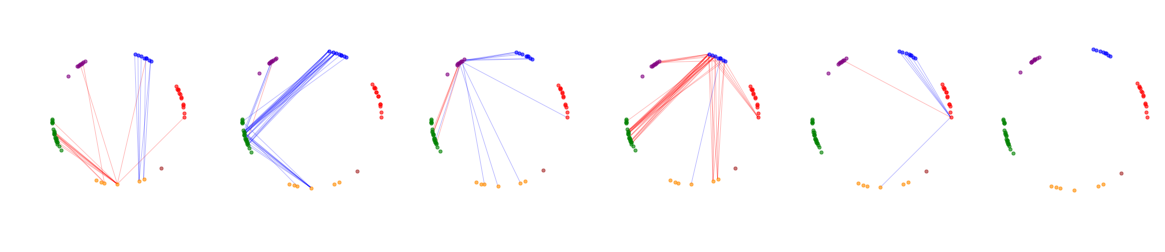

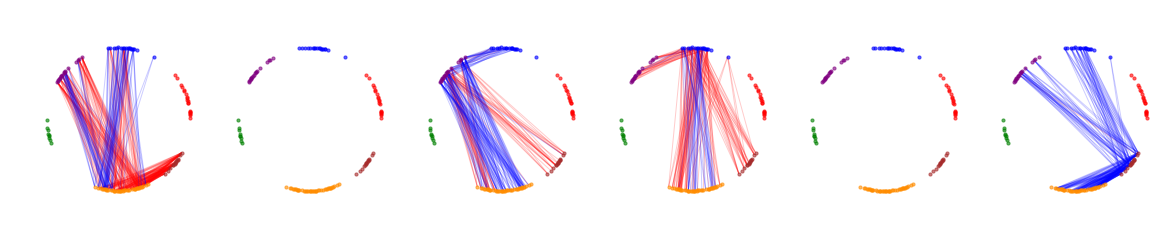

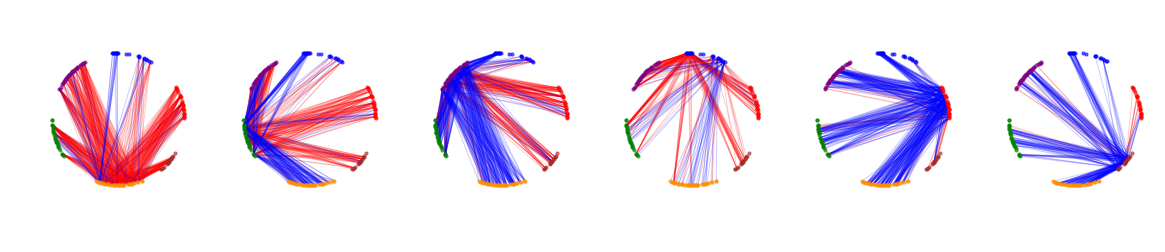

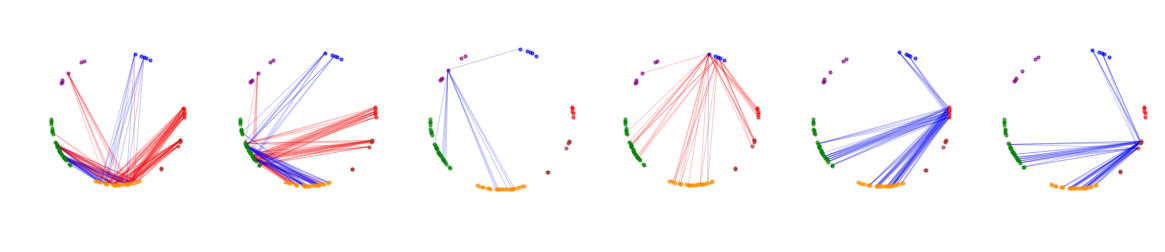

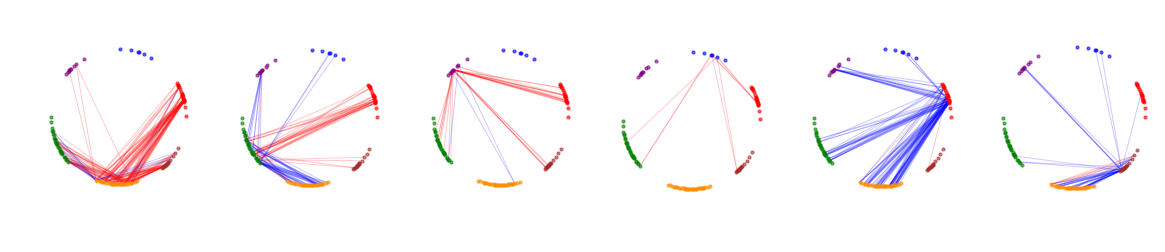

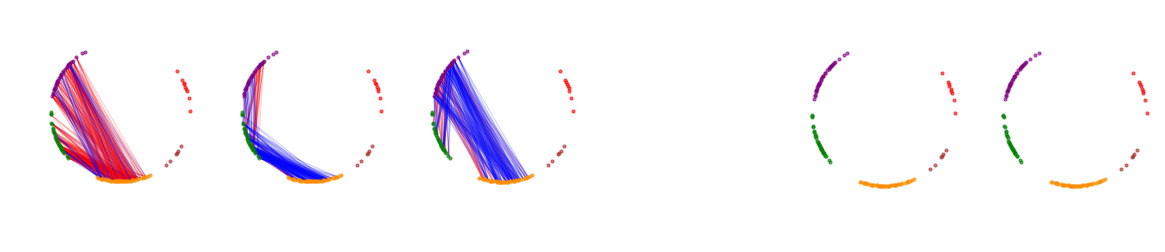

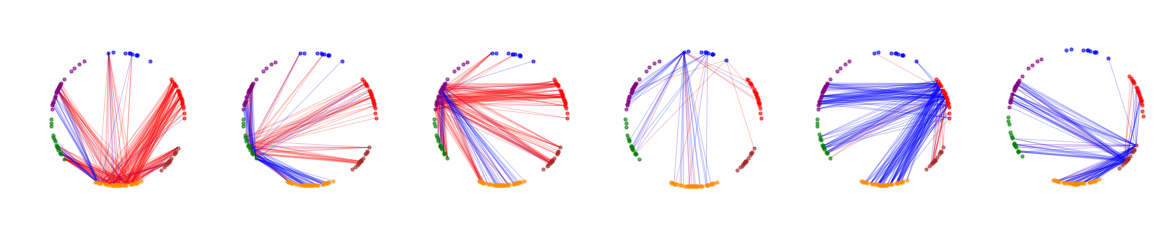

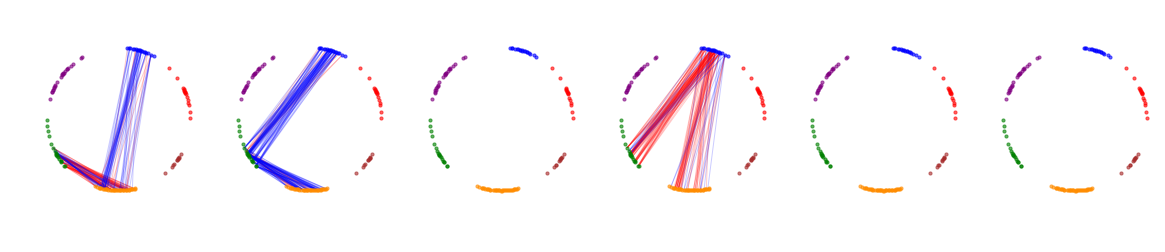

In [13]:
mouse_IDs = ['306046','388523', '389262',  '408153','410344', '415149', '412809', '412804',
             '416856', '419114',  '419117', '419118', '419119', '424445',
             '415148', '416356', '416861','419112','419116']

probe_reorder = ['probeC','probeD','probeE','probeF','probeA','probeB']
threshold=0.0000015

verbose = True
P_total=[]
DF_drive=[]
DF=[]
for mouse_ID in mouse_IDs:
    print(mouse_ID)
    # 1. load df
    X = np.load('/Users/xiaoxuanj/work/work_allen/Ephys/processed_data/adjacency_matrix/RF_onscreen/mouse'+mouse_ID+'_adjacency_matrix_RF.npy')
    
    df = pd.read_csv('/Users/xiaoxuanj/work/work_allen/Ephys/processed_data/meta_cluster_RF/mouse'+mouse_ID+'_meta_cluster_RF.csv')
    
    # get unique depth for each probe
    depth={}
    depth_all=[]
    new_probes=[]
    probenames = df.probe_id.unique()
    for probe in probenames:
        tmp = df[df.probe_id==probe].channel_id.unique()
        depth[probe]=list(tmp)
        depth_all.append(list(tmp))
        new_probes.append([probe]*len(tmp))
    depth_all = np.concatenate(depth_all, axis=0)
    new_probes = np.concatenate(new_probes, axis=0)
    n_nodes = len(depth_all)
    pos, probe_list, labels = set_nodes_position(df, depth_all)

    
    case='between'
    m=2
    n=3
    matrix = X[np.ix_(np.where(df.cluster==m)[0], np.where(df.cluster==n)[0])]
    tmp_X=np.zeros(np.shape(X))
    tmp_X[np.ix_(np.where(df.cluster==m)[0], np.where(df.cluster==n)[0])]=matrix
    new_matrix23 = condense_channel_matrix(tmp_X, df, case=case)

    m=3
    n=2
    matrix = X[np.ix_(np.where(df.cluster==m)[0], np.where(df.cluster==n)[0])]
    tmp_X=np.zeros(np.shape(X))
    tmp_X[np.ix_(np.where(df.cluster==m)[0], np.where(df.cluster==n)[0])]=matrix
    new_matrix32 = condense_channel_matrix(tmp_X, df, case=case)

    plt.figure(figsize=(20,4))
    for idx, probe in enumerate(probe_reorder):
        if probe in df.probe_id.unique():
            plt.subplot(1,6,idx+1)
            FG = nx.Graph()
            # draw nodes
            for p in probenames:
                nx.draw_networkx_nodes(FG,pos,
                                       nodelist=list(probe_list[p]),
                                       node_color=color_bank[p],
                                       node_size=10,
                                       alpha=0.6)
            plt.axis('equal')

            edgeP=new_matrix23
            # add positive edge
            for i in probe_list[probe]:
                for j in range(n_nodes):
                    if i!=j:
                        if abs(edgeP[i,j])>0.0000001:
                            FG.add_weighted_edges_from([(i,j, edgeP[i,j])])

            edgeP=new_matrix32
            # add positive edge
            for i in probe_list[probe]:
                for j in range(n_nodes):
                    if i!=j:
                        if abs(edgeP[i,j])>0.0000001:
                            FG.add_weighted_edges_from([(i,j, edgeP[i,j])])

            elarge=[(u,v) for (u,v,d) in FG.edges(data=True) if d['weight'] >threshold]
            nx.draw_networkx_edges(FG,pos,edgelist=elarge,width=1,edge_color='r', alpha=0.2)
            
            elarge=[(u,v) for (u,v,d) in FG.edges(data=True) if d['weight'] <-threshold]
            nx.draw_networkx_edges(FG,pos,edgelist=elarge,width=1,edge_color='b', alpha=0.2)

            plt.axis('off')
    plt.savefig('/Users/xiaoxuanj/Documents/presentations/CCN2019/presentation/figures/mouse'+mouse_ID+'_subnetworks_nx_all_new.pdf')

    